<h2>1. Contexte<h2/>

<h2>This notebook is dedicated to understanding the subject and exploring the data.<h2/>

<h3>"The dataset includes 174 metrics and 297,099 rows of data of tropical storms in the United States
collected from 1980 onwards. The data is raw, imperfect, and has not been cleaned or preprocessed."<h3/>

<h3>"Information about the dataset attributes can be found in the IBTRACS_variable_documentation file. Using the provided dataset, you are asked to train a model to predict the severity of a tropical cyclone based on geographical input data."<h3/>

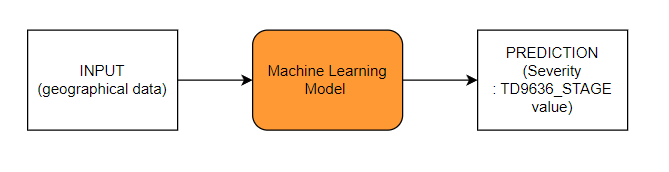

We want to predict the 145th column of the dataset 

<h2>2. Data Exploration<h2/>

In [ ]:
#Import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [76]:
#Import and read the csv file. Display the 5 first rows

df = pd.read_csv("ibtracs.csv")
df.head(5)

C:\Users\viala\AppData\Local\Temp\ipykernel_20436\1658390913.py:3: DtypeWarning: Columns (1,2,8,9,14,19,20,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ibtracs.csv")


,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,,Year,,,,,,,degrees_north,degrees_east,...,second,kts,second,ft,nmile,nmile,nmile,nmile,kts,degrees
1,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 00:00:00,TS,-12.5,172.5,...,,,,,,,,,6,350
2,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 03:00:00,TS,-12.2,172.4,...,,,,,,,,,6,350
3,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 06:00:00,TS,-11.9,172.4,...,,,,,,,,,5,360
4,1980001S13173,1980,1,SP,MM,PENI,1980-01-01 09:00:00,TS,-11.7,172.4,...,,,,,,,,,4,10


In [ ]:
# On repère les colonnes qui vont nous poser problèmes, ici les colonnes avec de NaN

df.isna().sum()

SID                  0
SEASON               0
NUMBER               0
BASIN            40518
SUBBASIN         32646
                 ...  
USA_SEARAD_SE        0
USA_SEARAD_SW        0
USA_SEARAD_NW        0
STORM_SPEED          0
STORM_DIR            0
Length: 174, dtype: int64

In [90]:
# On compte le nombre de NaN par colonne pour estimer le pourcentage du df que cela représenta

missing_values = df.isna().sum()
columns_with_missing = missing_values[missing_values > 0]
print(columns_with_missing,"\n\nCela représente environ:",round(40518/297000*100,2),"% du df pour BASIN", "\nEt", round(32646/297000*100,2),"% pour SUBBASIN")


BASIN       40518
SUBBASIN    32646
dtype: int64 

Cela représente environ: 13.64 % du df pour BASIN 
Et 10.99 % pour SUBBASIN


In [40]:
df.value_counts("BASIN")

BASIN
WP    99760
SI    62929
EP    47854
SP    31050
NI    14868
SA      119
          1
Name: count, dtype: int64

In [41]:
df.value_counts("SUBBASIN")

SUBBASIN
MM    197661
WA     24732
EA     10730
BB      9688
CP      8589
AS      5180
CS      4193
GM      3679
           1
Name: count, dtype: int64

<h4>Un premier problème se pose : les colonnes "BASIN" et "SUBBASIN" possèdent des données manquantes (BASIN 40518 & SUBBASIN 32646). De plus elles possèdent des valeurs dites MM (missing). Il faut déterminer leur pertinence dans ce dataset, pour savoir s'il faut les conserver ou non pour l'entrainement du modèle.<h4/>

In [ ]:
#Mapping des colonnes pour les encoder numériquement

basin_mapping = {val: idx for idx, val in enumerate(df['BASIN'].unique())}
subbasin_mapping = {val: idx for idx, val in enumerate(df['SUBBASIN'].unique())}

df['BASIN_encoded'] = df['BASIN'].map(basin_mapping)
df['SUBBASIN_encoded'] = df['SUBBASIN'].map(subbasin_mapping)


In [45]:
print(df[['BASIN', 'BASIN_encoded']].drop_duplicates())

       BASIN  BASIN_encoded
0                         0
1         SP              1
42        SI              2
1492      WP              3
1810      EP              4
2746     NaN              5
4983      NI              6
169717    SA              7


In [ ]:
print(df[['SUBBASIN', 'SUBBASIN_encoded']].drop_duplicates())

     SUBBASIN  SUBBASIN_encoded
0                             0
1          MM                 1
55         EA                 2
143        WA                 3
1810       CP                 4
2746      NaN                 5
2761       GM                 6
3215       CS                 7
4983       BB                 8
5045       AS                 9


In [ ]:
# Convertir les colonnes en type numérique (forcer les erreurs à NaN si des chaînes sont présentes)

df['BASIN_encoded'] = pd.to_numeric(df['BASIN_encoded'], errors='coerce')
df['SUBBASIN_encoded'] = pd.to_numeric(df['SUBBASIN_encoded'], errors='coerce')
df['TD9636_STAGE'] = pd.to_numeric(df['TD9636_STAGE'], errors='coerce')


In [55]:
# Vérifier les valeurs manquantes
print(df[['BASIN_encoded', 'SUBBASIN_encoded', 'TD9636_STAGE']].isna().sum())

# Supprimer les lignes contenant des NaN dans ces colonnes
df_cleaned = df.dropna(subset=['BASIN_encoded', 'SUBBASIN_encoded', 'TD9636_STAGE'])


BASIN_encoded            0
SUBBASIN_encoded         0
TD9636_STAGE        248756
dtype: int64


In [58]:
# Calculer la corrélation après nettoyage
correlation_basin = df_cleaned['BASIN_encoded'].corr(df_cleaned['TD9636_STAGE'])
correlation_subbasin = df_cleaned['SUBBASIN_encoded'].corr(df_cleaned['TD9636_STAGE'])

print(f"Corrélation entre BASIN_encoded et TD9636_STAGE : {correlation_basin}")
print(f"Corrélation entre SUBBASIN_encoded et TD9636_STAGE : {correlation_subbasin}")


Corrélation entre BASIN_encoded et TD9636_STAGE : 0.00230569887445233
Corrélation entre SUBBASIN_encoded et TD9636_STAGE : -0.044855441114447614


<h3>Analyse de ces deux colonnes : on peut voir une corrélation de 0.002 et -0.004, cela signifie BASIN et SUBBASIN ont un très faible impact sur la valeur de TD9636_STAGE. Nous pouvons prendre la décision de les supprimer.<h3/>

In [65]:
df.drop(columns=['BASIN', 'SUBBASIN'], inplace=True)

In [61]:
#Identification des colonnes qui possèdent la même valeur à chaque ligne, qui sont donc inutiles

columns_with_constant_values = df.nunique() == 1
constant_columns = df.columns[columns_with_constant_values]
print("Colonnes avec des valeurs constantes :")
print(constant_columns)


Colonnes avec des valeurs constantes :
Index([], dtype='object')


In [66]:
#Suppression de cette colonne 

df.drop(columns=['MLC_CLASS'], inplace=True)

<h3>On va maintenant encoder nos colonnes et les normaliser pour continuer notre étude. <h3/>

In [70]:
# Identifier les colonnes de type objet (string)
string_columns = df.select_dtypes(include=['object']).columns
print("Colonnes à encoder :", string_columns)

Colonnes à encoder : Index(['SID', 'SEASON', 'NUMBER', 'NAME', 'ISO_TIME', 'NATURE', 'LAT', 'LON',
       'WMO_WIND', 'WMO_PRES',
       ...
       'BOM_GUST_PER', 'REUNION_GUST', 'REUNION_GUST_PER', 'USA_SEAHGT',
       'USA_SEARAD_NE', 'USA_SEARAD_SE', 'USA_SEARAD_SW', 'USA_SEARAD_NW',
       'STORM_SPEED', 'STORM_DIR'],
      dtype='object', length=170)
